# NYC Taxi Data: Geospatial Analysis and Feature Engineering

This notebook focuses on geospatial analysis and feature engineering for NYC taxi data. We will integrate geographic data, visualize key locations like airports and tourist attractions, and engineer features related to these locations and specific events.

## Libraries and Initial Setup

We begin by importing the necessary libraries, initializing a Spark session, and loading the required datasets.

In [1]:
from pyspark.sql import SparkSession
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pyspark.sql import DataFrame
from shapely.geometry import Point
from pyspark.sql.functions import col, when, month, dayofmonth, date_format

In [2]:
# Initialize Spark Session
spark = (
    SparkSession.builder.appName("MAST30034 Project 1")  # Name the Spark application
    .config("spark.sql.repl.eagerEval.enabled", True)  # Enable eager evaluation for interactive querying
    .config("spark.sql.parquet.cacheMetadata", "true")  # Cache metadata for parquet files
    .config("spark.sql.session.timeZone", "Etc/UTC")  # Set the timezone to UTC
    .getOrCreate()  # Create or retrieve the existing Spark session
)

24/08/24 23:35:35 WARN Utils: Your hostname, apples-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.13.11.182 instead (on interface en0)
24/08/24 23:35:35 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/24 23:35:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
def shape(sdf: DataFrame) -> None:
    """
    Returns the shape of a Spark DataFrame as a tuple (number of rows, number of columns).

    :param sdf: Spark DataFrame
    :return: String stating the shape of sdf
    """
    num_rows = sdf.count()
    num_columns = len(sdf.columns)
    print(f"Shape of the DataFrame: {num_rows} rows, {num_columns} columns.")

## Prepare Dataframe for processing

Load the curated NYC taxi data into a Spark DataFrame for further processing and feature engineering.

In [4]:
# Load the curated data from parquet file
sdf = spark.read.parquet('/Users/jennymai/Desktop/data_sci/mast_project1/data/curated')

In [5]:
shape(sdf)

Shape of the DataFrame: 5016231 rows, 26 columns.


Load the CSV file containing taxi zone lookup data and the shapefile containing the geometric boundaries of these zones. These datasets will be used for spatial analysis.

In [6]:
# Define file paths for geographic data
csv_file_path = '/Users/jennymai/Desktop/data_sci/mast_project1/data/landing_taxi_zones/taxi_zone_lookup.csv'
shapefile_path = '/Users/jennymai/Desktop/data_sci/mast_project1/data/landing_taxi_zones/taxi_zones.shp'

Merge the taxi zone lookup data with the shapefile data to create a GeoDataFrame that contains both geometric and attribute data. This will allow for spatial analysis and visualization of different zones in NYC.

In [7]:
# Load the shapefile and CSV data
gdf = gpd.read_file(shapefile_path)  # Load the shapefile into a GeoDataFrame
df = pd.read_csv(csv_file_path)  # Load the CSV file into a DataFrame

In [9]:
print(gdf.shape)
print(df.shape)

(263, 7)
(265, 4)


In [10]:
# Merge the geographic and attribute data on LocationID
merged_gdf = gdf.merge(df, left_on='LocationID', right_on='LocationID', how='left')
print(merged_gdf.shape)
merged_gdf

(263, 10)


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,Borough,Zone,service_zone
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",EWR,Newark Airport,EWR
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343...",Queens,Jamaica Bay,Boro Zone
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2...",Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",Manhattan,Alphabet City,Yellow Zone
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144...",Staten Island,Arden Heights,Boro Zone
...,...,...,...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((1025414.782 270986.139, 1025138.624 ...",Bronx,Woodlawn/Wakefield,Boro Zone
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((1011466.966 216463.005, 1011545.889 ...",Queens,Woodside,Boro Zone
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((980555.204 196138.486, 980570.792 19...",Manhattan,World Trade Center,Yellow Zone
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((999804.795 224498.527, 999824....",Manhattan,Yorkville East,Yellow Zone


## Unique Taxi Zones

Print the unique taxi zones available in the merged GeoDataFrame to understand the coverage of the dataset.

In [11]:
# Display the unique zones in the GeoDataFrame
unique_zones = merged_gdf['zone'].unique()
print(unique_zones)

['Newark Airport' 'Jamaica Bay' 'Allerton/Pelham Gardens' 'Alphabet City'
 'Arden Heights' 'Arrochar/Fort Wadsworth' 'Astoria' 'Astoria Park'
 'Auburndale' 'Baisley Park' 'Bath Beach' 'Battery Park'
 'Battery Park City' 'Bay Ridge' 'Bay Terrace/Fort Totten' 'Bayside'
 'Bedford' 'Bedford Park' 'Bellerose' 'Belmont' 'Bensonhurst East'
 'Bensonhurst West' 'Bloomfield/Emerson Hill' 'Bloomingdale' 'Boerum Hill'
 'Borough Park' 'Breezy Point/Fort Tilden/Riis Beach'
 'Briarwood/Jamaica Hills' 'Brighton Beach' 'Broad Channel' 'Bronx Park'
 'Bronxdale' 'Brooklyn Heights' 'Brooklyn Navy Yard' 'Brownsville'
 'Bushwick North' 'Bushwick South' 'Cambria Heights' 'Canarsie'
 'Carroll Gardens' 'Central Harlem' 'Central Harlem North' 'Central Park'
 'Charleston/Tottenville' 'Chinatown' 'City Island' 'Claremont/Bathgate'
 'Clinton East' 'Clinton Hill' 'Clinton West' 'Co-Op City' 'Cobble Hill'
 'College Point' 'Columbia Street' 'Coney Island' 'Corona' 'Country Club'
 'Crotona Park' 'Crotona Park East' 'C

## Identify Airport Zones

Identify and display the LocationIDs associated with airports by filtering the zones that contain the word "Airport". This will help in analyzing airport-related trips.

In [12]:
# Filter the zones that correspond to airports
airport_location_ids = merged_gdf[merged_gdf['zone'].str.contains('Airport', case=False, na=False)]
print(airport_location_ids[['zone', 'LocationID']])

                  zone  LocationID
0       Newark Airport           1
131        JFK Airport         132
137  LaGuardia Airport         138


## Identify Tourist Attraction Zones

Identify and display the LocationIDs associated with major tourist attractions in NYC. These locations will be used to analyze trips related to tourism. These zones were manually selected based on knowledge obtained from Internet search.

In [13]:
# Define a list of major tourist attractions in NYC
tourist_attractions = [
    'Central Park', 'Times Sq/Theatre District', 'Governor\'s Island/Ellis Island/Liberty Island',
    'World Trade Center', 'Battery Park', 'Battery Park City', 'Chinatown',
    'Financial District North', 'Financial District South', 'Greenwich Village North',
    'Greenwich Village South', 'SoHo', 'Midtown Center', 'Midtown East',
    'Midtown North', 'Midtown South'
]

# Filter the zones that correspond to tourist attractions
tourist_location_ids = merged_gdf[merged_gdf['zone'].isin(tourist_attractions)]
print(tourist_location_ids[['zone', 'LocationID']])

                                              zone  LocationID
11                                    Battery Park          12
12                               Battery Park City          13
42                                    Central Park          43
44                                       Chinatown          45
86                        Financial District North          87
87                        Financial District South          88
102  Governor's Island/Ellis Island/Liberty Island         103
103  Governor's Island/Ellis Island/Liberty Island         103
104  Governor's Island/Ellis Island/Liberty Island         103
112                        Greenwich Village North         113
113                        Greenwich Village South         114
160                                 Midtown Center         161
161                                   Midtown East         162
162                                  Midtown North         163
163                                  Midtown South     

## Prepare Location ID Lists

Manually define lists of LocationIDs for airports and tourist attractions for use in subsequent feature engineering. These lists were manually constructed after conducting Internet research.

In [14]:
# Define lists of LocationIDs for airports and tourist attractions
airport_location_ids = [1, 132, 138]
tourist_location_ids = [12, 13, 43, 45, 86, 87, 102, 103, 112, 113, 114, 161, 162, 163, 164, 210, 230, 260]

In [15]:
merged_gdf.columns

Index(['OBJECTID', 'Shape_Leng', 'Shape_Area', 'zone', 'LocationID', 'borough',
       'geometry', 'Borough', 'Zone', 'service_zone'],
      dtype='object')

## Visualize NYC Taxi Zones and Airport Locations

Create a visualization of NYC taxi zones colored by borough, with airport locations marked. This will help in visualizing the spatial distribution of taxi zones and their proximity to major airports.

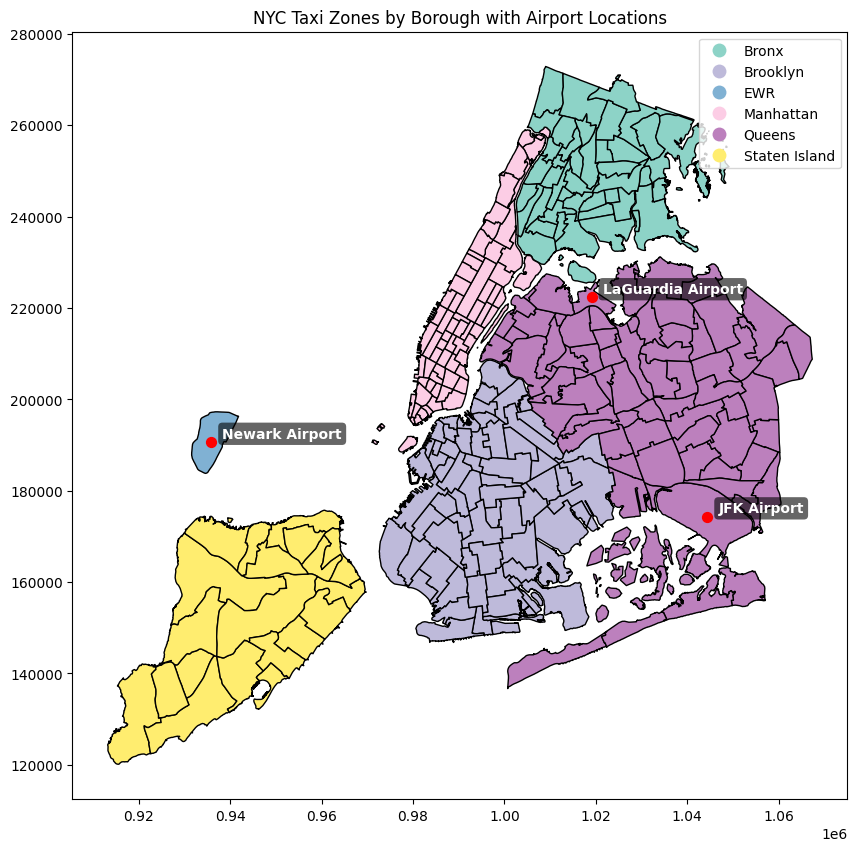

In [16]:
# Define the coordinates of major airports
airports = {
    'JFK Airport': (-73.78318941299524, 40.644993757971534),
    'LaGuardia Airport': (-73.8742509622028, 40.776772192400315),
    'Newark Airport': (-74.17454822996676, 40.68985680628578)
}

# Create a GeoDataFrame for airports
airport_gdf = gpd.GeoDataFrame(
    list(airports.items()),
    columns=['Name', 'Coordinates'],
    geometry=[Point(xy) for xy in airports.values()],
    crs="EPSG:4326"  # Set the coordinate reference system
)

# Convert airport GeoDataFrame to match the CRS of the merged GeoDataFrame
airport_gdf = airport_gdf.to_crs(merged_gdf.crs)

# Plot NYC taxi zones by borough and overlay airport locations
fig, ax = plt.subplots(figsize=(10, 10))
merged_gdf.plot(column='Borough', ax=ax, legend=True, cmap='Set3', edgecolor='black')  # Plot taxi zones by borough

# Plot airport locations
airport_gdf.plot(ax=ax, color='red', markersize=50, zorder=2)
for x, y, label in zip(airport_gdf.geometry.x, airport_gdf.geometry.y, airport_gdf['Name']):
    ax.annotate(label, (x, y), fontsize=10, color='white', weight='bold', ha='left',
                bbox=dict(facecolor='black', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.3'),
                xytext=(8, 3), textcoords='offset points')

plt.title("NYC Taxi Zones by Borough with Airport Locations")
plt.show()  # Display the plot

## Feature Engineering: Airport and Tourist Trip Indicators

Create binary indicators in the DataFrame to identify trips that either start or end at an airport or tourist attraction. These features will be useful for analyzing the impact of such locations on trip characteristics.

In [17]:
shape(sdf)

Shape of the DataFrame: 5016231 rows, 26 columns.


In [18]:
# Create a binary indicator for trips involving airports
sdf = sdf.withColumn(
    'is_airport_trip',
    when(col('PULocationID').isin(airport_location_ids) | col('DOLocationID').isin(airport_location_ids), 1).otherwise(0)
)

# Create a binary indicator for trips involving tourist attractions
sdf = sdf.withColumn(
    'is_tourist_trip',
    when(col('PULocationID').isin(tourist_location_ids) | col('DOLocationID').isin(tourist_location_ids), 1).otherwise(0)
)

# Create binary indicators for pickup and dropoff at airports
sdf = sdf.withColumn(
    'pickup_at_airport',
    when(col('PULocationID').isin(airport_location_ids), 1).otherwise(0)
).withColumn(
    'dropoff_at_airport',
    when(col('DOLocationID').isin(airport_location_ids), 1).otherwise(0)
)

# Create binary indicators for pickup and dropoff at tourist attractions
sdf = sdf.withColumn(
    'pickup_at_tourist_attraction',
    when(col('PULocationID').isin(tourist_location_ids), 1).otherwise(0)
).withColumn(
    'dropoff_at_tourist_attraction',
    when(col('DOLocationID').isin(tourist_location_ids), 1).otherwise(0)
)

# Display the first 10 rows of the modified DataFrame
sdf.limit(10)

24/08/24 23:40:48 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration_mins,pickup_hour,pickup_dayofweek,dropoff_hour,dropoff_dayofweek,days_since_2022_11_01,distance_time_interaction,is_airport_trip,is_tourist_trip,pickup_at_airport,dropoff_at_airport,pickup_at_tourist_attraction,dropoff_at_tourist_attraction
1,2022-12-01 00:37:35,2022-12-01 00:47:35,1.0,2.0,1.0,0,170,237,1,8.5,3.0,0.5,3.1,0.0,0.3,15.4,2.5,0.0,10.0,0,5,0,5,30,0.0,0,0,0,0,0,0
1,2022-12-01 00:33:26,2022-12-01 00:37:34,1.0,0.8,1.0,0,140,140,1,5.0,3.0,0.5,1.76,0.0,0.3,10.56,2.5,0.0,4.133333333333334,0,5,0,5,30,0.0,0,0,0,0,0,0
1,2022-12-01 00:45:51,2022-12-01 00:53:16,1.0,3.0,1.0,0,141,79,3,10.0,3.0,0.5,0.0,0.0,0.3,13.8,2.5,0.0,7.416666666666667,0,5,0,5,30,0.0,0,0,0,0,0,0
2,2022-12-01 00:49:49,2022-12-01 00:54:13,1.0,0.76,1.0,0,261,231,1,5.0,0.5,0.5,1.76,0.0,0.3,10.56,2.5,0.0,4.4,0,5,0,5,30,0.0,0,0,0,0,0,0
1,2022-12-01 00:25:25,2022-12-01 00:35:38,2.0,2.6,1.0,0,237,164,1,10.5,3.0,0.5,4.25,0.0,0.3,18.55,2.5,0.0,10.216666666666667,0,5,0,5,30,0.0,0,1,0,0,0,1
2,2022-12-01 00:05:37,2022-12-01 00:10:48,1.0,0.94,1.0,0,79,144,1,5.5,0.5,0.5,1.86,0.0,0.3,11.16,2.5,0.0,5.183333333333334,0,5,0,5,30,0.0,0,0,0,0,0,0
2,2022-12-01 00:20:12,2022-12-01 00:28:49,1.0,2.09,1.0,0,79,186,1,9.0,0.5,0.5,2.0,0.0,0.3,14.8,2.5,0.0,8.616666666666667,0,5,0,5,30,0.0,0,0,0,0,0,0
1,2022-12-01 00:00:54,2022-12-01 00:05:41,1.0,0.8,1.0,0,142,143,1,5.5,3.0,0.5,1.85,0.0,0.3,11.15,2.5,0.0,4.783333333333333,0,5,0,5,30,0.0,0,0,0,0,0,0
2,2022-12-01 00:11:23,2022-12-01 00:30:00,1.0,7.62,1.0,0,138,255,1,24.0,0.5,0.5,5.31,0.0,0.3,31.86,0.0,1.25,18.616666666666667,0,5,0,5,30,0.0,1,0,1,0,0,0
1,2022-12-01 00:14:29,2022-12-01 00:30:10,2.0,3.1,1.0,0,234,143,1,13.0,3.0,0.5,1.68,0.0,0.3,18.48,2.5,0.0,15.683333333333334,0,5,0,5,30,0.0,0,0,0,0,0,0


In [19]:
# Holiday Season: Late December to early January (December 20 - January 5)
sdf = sdf.withColumn(
    'is_holiday_season',
    when(
        ((month(col('tpep_pickup_datetime')) == 12) & (dayofmonth(col('tpep_pickup_datetime')) >= 20)) |
        ((month(col('tpep_pickup_datetime')) == 1) & (dayofmonth(col('tpep_pickup_datetime')) <= 5)), 1
    ).otherwise(0)
)

# Major Events
event_dates = [
    '2022-12-31',  # New Year's Eve
    '2022-07-04',  # Independence Day
    '2022-11-24',  # Thanksgiving
    '2023-12-31',  # New Year's Eve
    '2023-07-04',  # Independence Day
    '2023-11-24'   # Thanksgiving
]

# Add is_event_day column
sdf = sdf.withColumn(
    'is_event_day',
    when(date_format(col('tpep_pickup_datetime'), 'yyyy-MM-dd').isin(event_dates), 1).otherwise(0)
)

sdf.limit(10)

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration_mins,pickup_hour,pickup_dayofweek,dropoff_hour,dropoff_dayofweek,days_since_2022_11_01,distance_time_interaction,is_airport_trip,is_tourist_trip,pickup_at_airport,dropoff_at_airport,pickup_at_tourist_attraction,dropoff_at_tourist_attraction,is_holiday_season,is_event_day
1,2022-12-01 00:37:35,2022-12-01 00:47:35,1.0,2.0,1.0,0,170,237,1,8.5,3.0,0.5,3.1,0.0,0.3,15.4,2.5,0.0,10.0,0,5,0,5,30,0.0,0,0,0,0,0,0,0,0
1,2022-12-01 00:33:26,2022-12-01 00:37:34,1.0,0.8,1.0,0,140,140,1,5.0,3.0,0.5,1.76,0.0,0.3,10.56,2.5,0.0,4.133333333333334,0,5,0,5,30,0.0,0,0,0,0,0,0,0,0
1,2022-12-01 00:45:51,2022-12-01 00:53:16,1.0,3.0,1.0,0,141,79,3,10.0,3.0,0.5,0.0,0.0,0.3,13.8,2.5,0.0,7.416666666666667,0,5,0,5,30,0.0,0,0,0,0,0,0,0,0
2,2022-12-01 00:49:49,2022-12-01 00:54:13,1.0,0.76,1.0,0,261,231,1,5.0,0.5,0.5,1.76,0.0,0.3,10.56,2.5,0.0,4.4,0,5,0,5,30,0.0,0,0,0,0,0,0,0,0
1,2022-12-01 00:25:25,2022-12-01 00:35:38,2.0,2.6,1.0,0,237,164,1,10.5,3.0,0.5,4.25,0.0,0.3,18.55,2.5,0.0,10.216666666666667,0,5,0,5,30,0.0,0,1,0,0,0,1,0,0
2,2022-12-01 00:05:37,2022-12-01 00:10:48,1.0,0.94,1.0,0,79,144,1,5.5,0.5,0.5,1.86,0.0,0.3,11.16,2.5,0.0,5.183333333333334,0,5,0,5,30,0.0,0,0,0,0,0,0,0,0
2,2022-12-01 00:20:12,2022-12-01 00:28:49,1.0,2.09,1.0,0,79,186,1,9.0,0.5,0.5,2.0,0.0,0.3,14.8,2.5,0.0,8.616666666666667,0,5,0,5,30,0.0,0,0,0,0,0,0,0,0
1,2022-12-01 00:00:54,2022-12-01 00:05:41,1.0,0.8,1.0,0,142,143,1,5.5,3.0,0.5,1.85,0.0,0.3,11.15,2.5,0.0,4.783333333333333,0,5,0,5,30,0.0,0,0,0,0,0,0,0,0
2,2022-12-01 00:11:23,2022-12-01 00:30:00,1.0,7.62,1.0,0,138,255,1,24.0,0.5,0.5,5.31,0.0,0.3,31.86,0.0,1.25,18.616666666666667,0,5,0,5,30,0.0,1,0,1,0,0,0,0,0
1,2022-12-01 00:14:29,2022-12-01 00:30:10,2.0,3.1,1.0,0,234,143,1,13.0,3.0,0.5,1.68,0.0,0.3,18.48,2.5,0.0,15.683333333333334,0,5,0,5,30,0.0,0,0,0,0,0,0,0,0


In [20]:
shape(sdf)

Shape of the DataFrame: 5016231 rows, 34 columns.


The DataFrame now has 34 columns instead of 26 previously.

After all feature engineering steps have been completed, the cleaned and enriched DataFrame is saved to a new Parquet file. This ensures that the processed data is stored efficiently and is ready for further analysis or modeling.


In [17]:
# Save the cleaned and feature-engineered DataFrame to a new Parquet file
sdf.write.parquet('/Users/jennymai/Desktop/data_sci/mast_project1/data/curated2', mode='overwrite')

The merged GeoDataFrame, which includes both the geometric shapes of the NYC taxi zones and their associated attributes, is saved to a Shapefile. This file format preserves the spatial information and can be used in GIS software or further geospatial analysis.

In [18]:
# Save the merged GeoDataFrame to a Shapefile for future geospatial analysis
merged_gdf.to_file("/Users/jennymai/Desktop/data_sci/mast_project1/data/raw_taxi_zones/merged_gdf.shp")

/var/folders/27/hm8cnznd78x3flv3w2sfvqwm0000gp/T/ipykernel_87523/2096467216.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  merged_gdf.to_file("/Users/jennymai/Desktop/data_sci/mast_project1/data/raw_taxi_zones/merged_gdf.shp")


/usr/local/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'Borough' to 'Borough_1'
  ogr_write(
/usr/local/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'Zone' to 'Zone_1'
  ogr_write(
/usr/local/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'service_zone' to 'service_zo'
  ogr_write(


24/08/21 00:55:14 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 919203 ms exceeds timeout 120000 ms
24/08/21 00:55:14 WARN SparkContext: Killing executors is not supported by current scheduler.
24/08/21 00:55:17 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at o

In [21]:
# Stop the Spark session to release resources
spark.stop()